# Семинар_2: Методы фильтрации признаков

Цель семинара: освоить методы фильтрации признаков

План семинара:

    Посмотрим прогресс по соревнованию на Kaggle
    Практика - решим три задачи на поиск рандомных признаков и фильтрацию датасета соревнования
    Подведение итогов - проанализируем и обсудим алгоритмы фильтрации, получим список "мусорных" фичей соревнования


In [1]:
import shap
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn import metrics

import numpy as np
from catboost import CatBoostClassifier, Pool
import pandas as pd
pd.set_option('display.max_columns', None)

## 1. Разминка (10 минут)

* Дан датасет, собранный из учебного про поломки машин
* В нём 5 реальных признаков и 5 рандомно сгенерированных
* Используя любые методы из лекций (не менее 2-х), определите номера реальных признаков

*Не стоит сразу пытаться запускать тяжёлые алгоритмы, возможно, будет достаточно простых методов

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/779915/fs_task1_10f.csv')
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,2015,163.000000,-1.450726,0.5,332,-0.018070,170,-9,0.10,50.339080,engine_ignition
1,2014,108.451384,2.233679,0.4,425,-0.849765,173,16,0.10,44.367816,break_bug
2,2010,167.738026,-8.024895,-0.8,50,0.134024,171,-9,0.10,44.902299,engine_check
3,2018,167.000000,-0.201363,2.0,224,-0.985060,173,-2,0.52,44.770115,engine_check
4,2019,183.000000,14.666233,0.8,351,0.606498,170,13,0.10,45.241379,another_bug


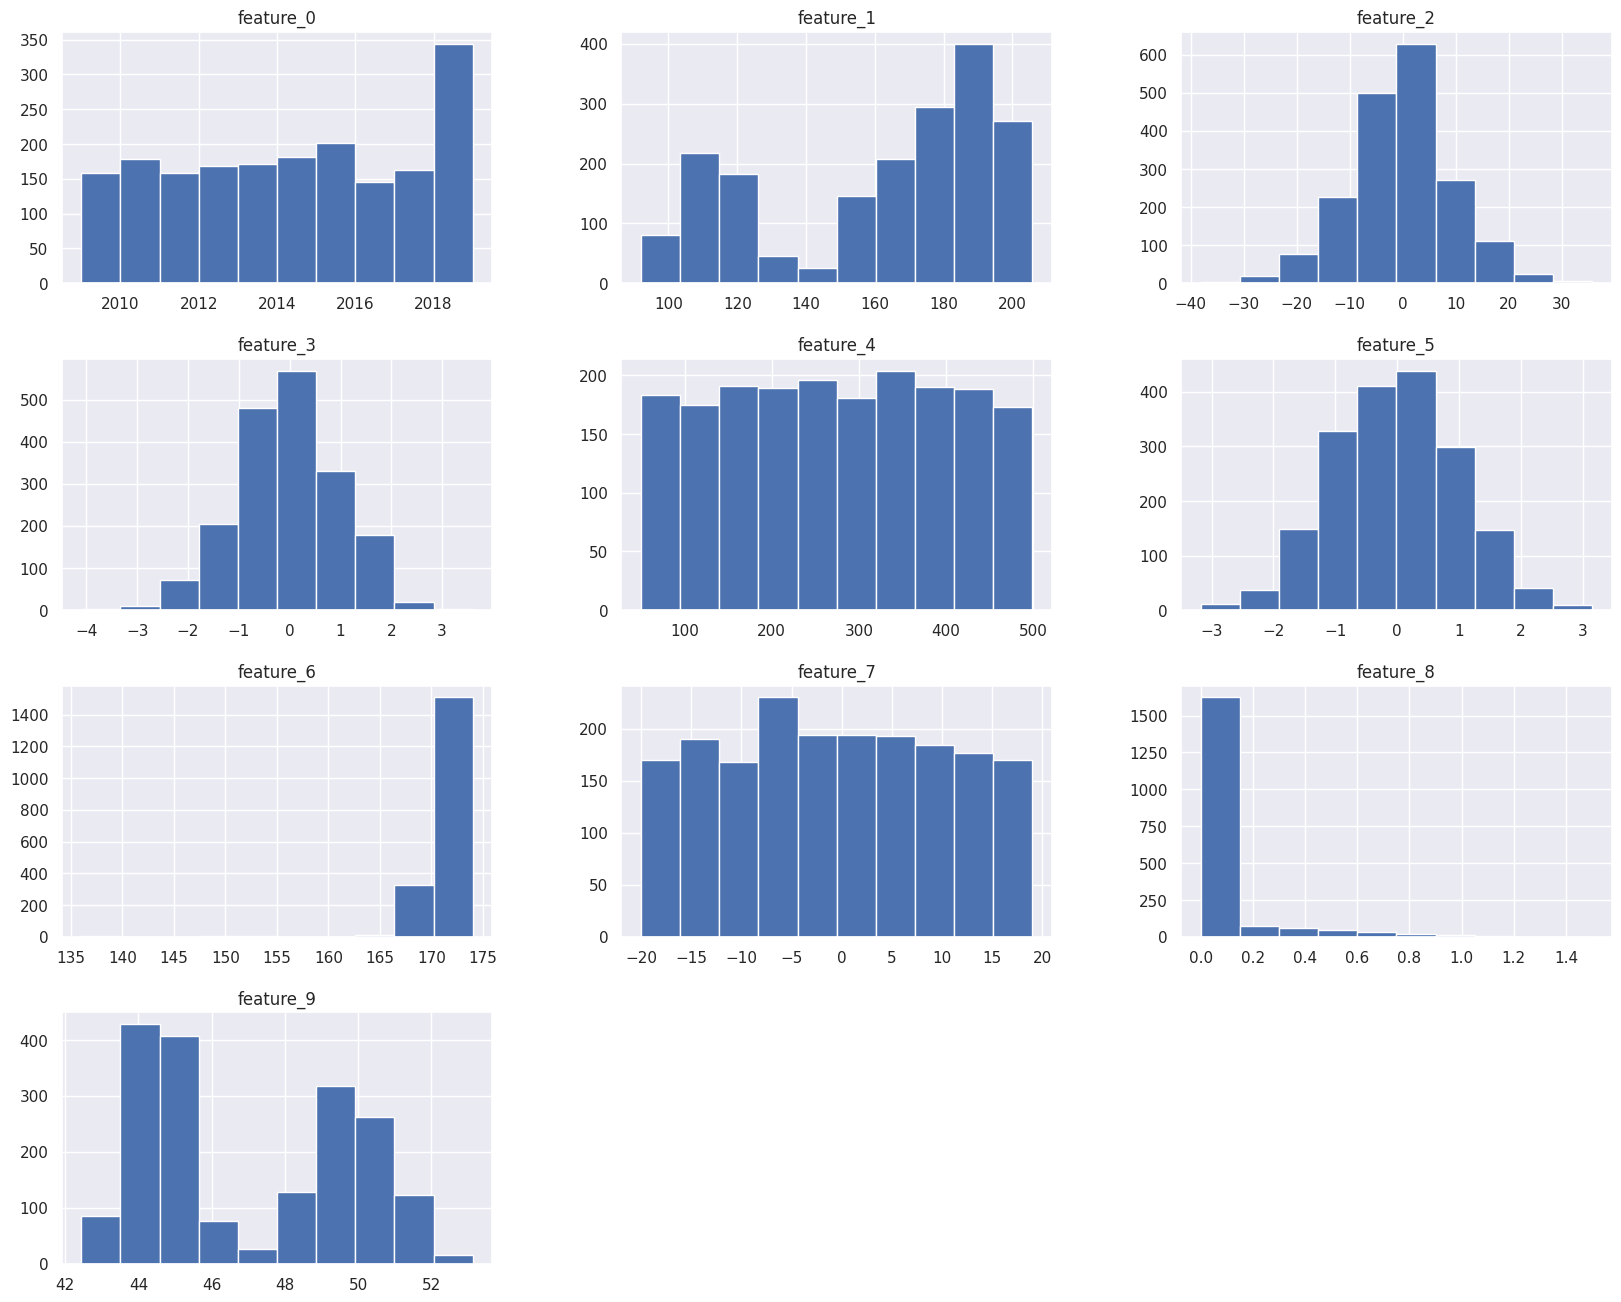

In [3]:
sns.set(rc={'figure.figsize': (20, 16)})
df.hist();

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], 
                                                    test_size=0.2,random_state=43)

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


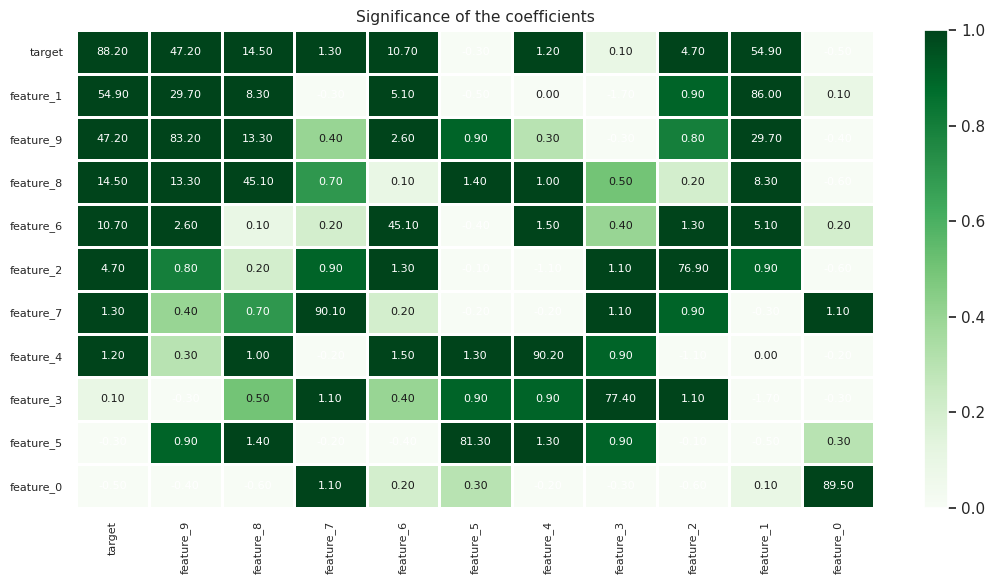

In [5]:
# PHIK
significance_overview = df.significance_matrix().fillna(0).round(1).sort_values('target')

plot_correlation_matrix(significance_overview.values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients",
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [6]:
# Если вдруг понадобится модель
model = CatBoostClassifier(random_seed=43)

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)

Learning rate set to 0.10885
0:	learn: 1.9550469	test: 1.9486753	best: 1.9486753 (0)	total: 74.2ms	remaining: 1m 14s
50:	learn: 0.5989108	test: 0.7130524	best: 0.7130524 (50)	total: 573ms	remaining: 10.7s
100:	learn: 0.4681329	test: 0.6691602	best: 0.6691602 (100)	total: 1.05s	remaining: 9.37s
150:	learn: 0.3887796	test: 0.6531451	best: 0.6524817 (148)	total: 1.54s	remaining: 8.64s
200:	learn: 0.3344958	test: 0.6507969	best: 0.6502243 (197)	total: 2.02s	remaining: 8.04s
250:	learn: 0.2918402	test: 0.6455235	best: 0.6437981 (239)	total: 2.51s	remaining: 7.49s
300:	learn: 0.2523184	test: 0.6486495	best: 0.6437981 (239)	total: 3s	remaining: 6.97s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6437980629
bestIteration = 239

Shrink model to first 240 iterations.


In [7]:
# смотрим важность признаков
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,feature_1,34.024600
1,feature_9,29.162694
2,feature_8,12.113123
3,feature_2,4.511243
4,feature_6,3.916620
5,feature_4,3.814459
6,feature_7,3.567247
7,feature_5,3.364486
8,feature_3,2.881618
9,feature_0,2.643909


In [8]:
# Добавьте названия мусорных фичей в список
trash_features = ['feature_4', 'feature_7',
                  'feature_5','feature_3','feature_0']

# 2. Фильтрация признаков из датасета соревнования (30 мин)
Цель: Проанализировав датасет различными алгоритмами, собрать список мусорных признаков и ппроверить, как это скажется на итоговом скоре

### 2.1 Добавьте в датасет 2 рандомных признака random_num и random_int (10 мин)
* постройте матрицу корреляций phik (significance overview)
* посмотреть важность признаков CatBoost и как изменился скор после добавления рандомных признаков
* Найти признаки, которые по важности оказались ниже рандомных - занести в список

In [9]:
# Подгружаем мультиклассовый датасет из прошлого ноутбука
train = pd.read_csv('/kaggle/input/seminar1/train_multiclass.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,3
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,6
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,2
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,2
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,6


In [10]:
# Добавляем рандомные признаки
train['random_int'] = np.random.randint(0, 1200, train.shape[0])
train['random_num'] = np.random.random(size = train.shape[0])
train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target,random_int,random_num
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,3,626,0.596857
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,6,377,0.946735
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,2,909,0.115336
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,2,153,0.252705
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,6,1091,0.301163


In [11]:
targets = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']


X = train.drop(columns=targets + ['target', 'id'])
y = train['target']

interval columns not set, guessing: ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'target', 'random_int', 'random_num']


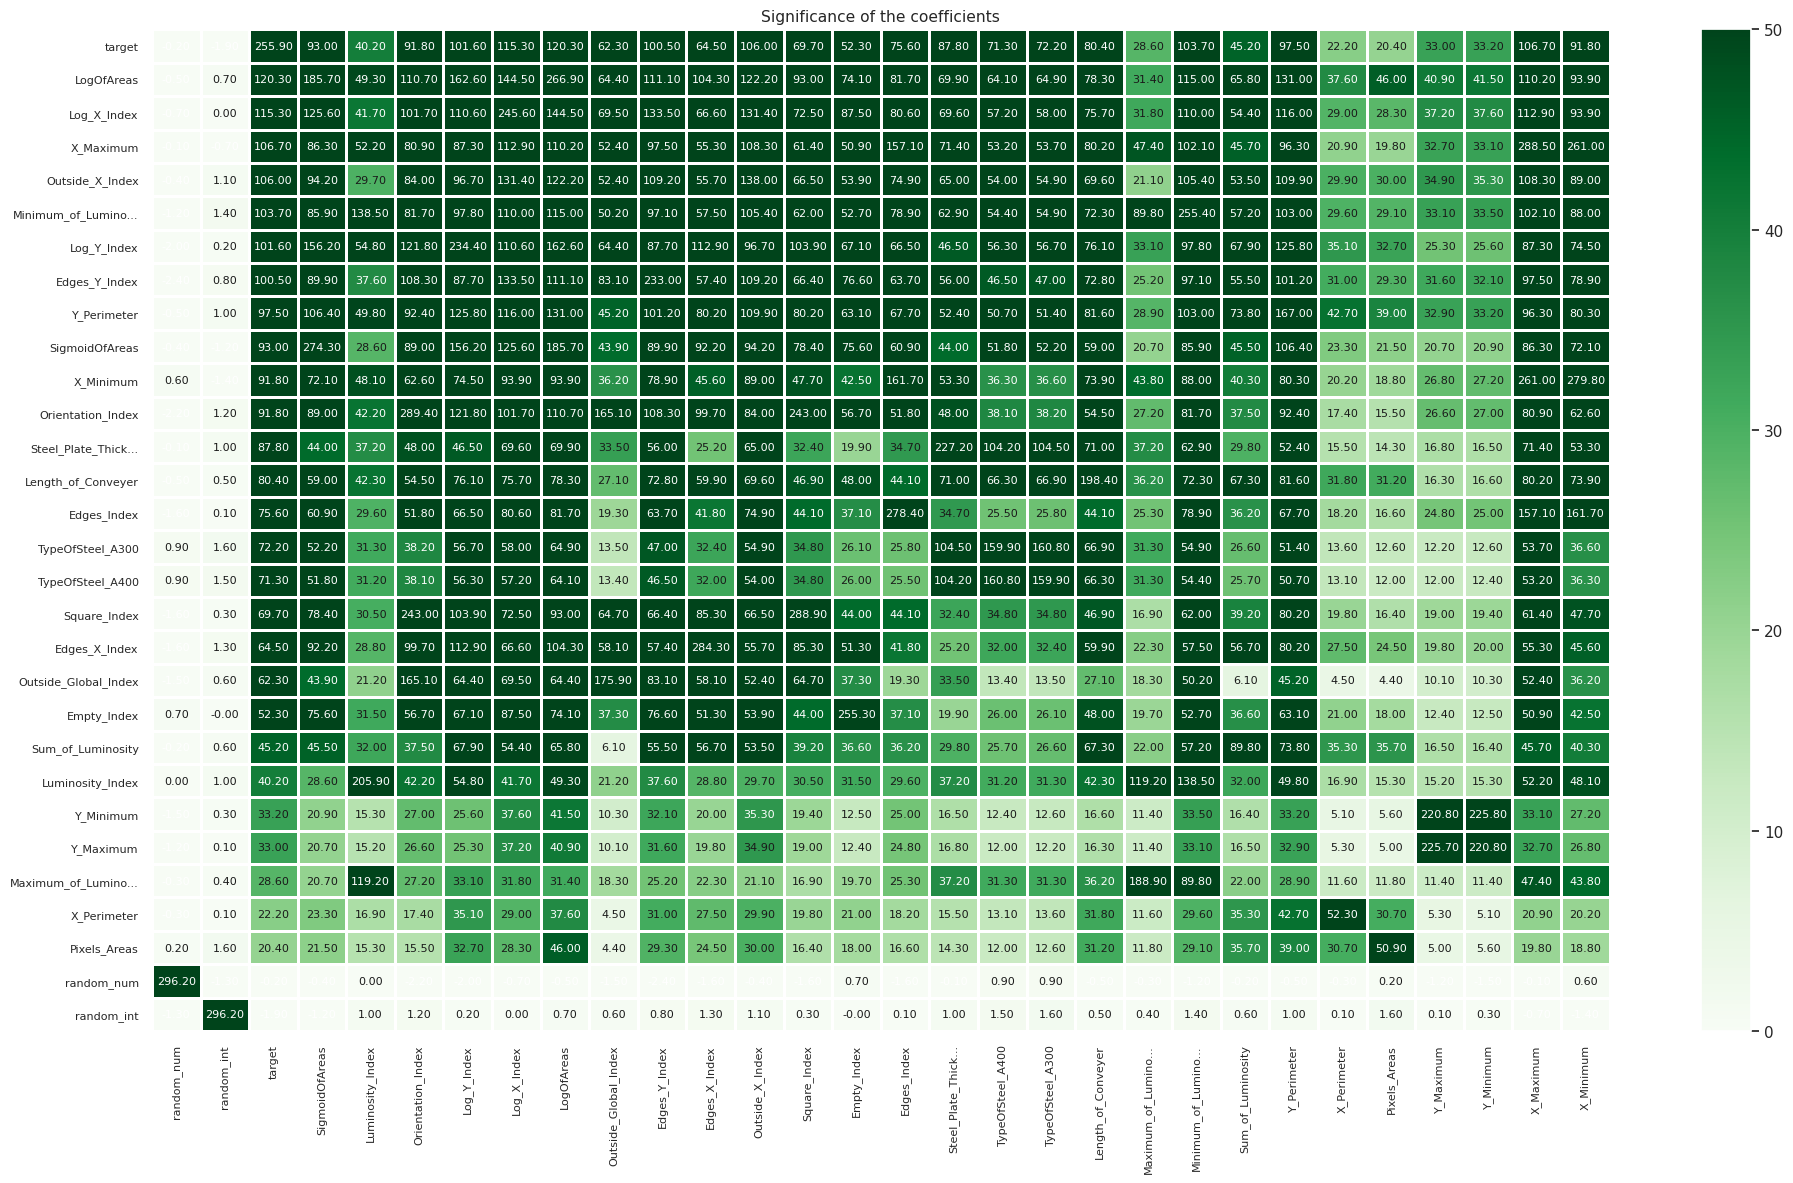

In [12]:
# PHIK
significance_overview = train.drop(columns=targets + ['id']).significance_matrix().fillna(0).round(1).sort_values('target')

plot_correlation_matrix(significance_overview.values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=0, vmax=50, color_map="Greens",
                        title="Significance of the coefficients",
                        usetex=False, fontsize_factor=0.8,figsize=(20, 12))
plt.tight_layout()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  random_state=43, stratify=y)

In [14]:
model = CatBoostClassifier(random_seed=43,
                           #ignored_features=[],
                           eval_metric='AUC',
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Learning rate set to 0.114039
0:	test: 0.8129070	best: 0.8129070 (0)	total: 64.5ms	remaining: 1m 4s
50:	test: 0.9109821	best: 0.9109821 (50)	total: 2.29s	remaining: 42.7s
100:	test: 0.9160338	best: 0.9160338 (100)	total: 4.5s	remaining: 40s
150:	test: 0.9181558	best: 0.9183769 (148)	total: 6.68s	remaining: 37.5s
200:	test: 0.9187067	best: 0.9188933 (197)	total: 8.87s	remaining: 35.3s
250:	test: 0.9182385	best: 0.9188933 (197)	total: 10.9s	remaining: 32.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.91889331
bestIteration = 197

Shrink model to first 198 iterations.
{'learn': {'MultiClass': 0.8079367933058665}, 'validation': {'AUC:type=Mu': 0.9188933100020317, 'MultiClass': 1.0411512234649944}}


In [15]:
# смотрим важность признаков
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Steel_Plate_Thickness,11.622666
1,Length_of_Conveyer,11.065597
2,Orientation_Index,5.521221
3,Minimum_of_Luminosity,4.703644
4,Edges_Index,4.171963
5,Log_X_Index,4.019706
6,X_Maximum,3.993751
7,Edges_Y_Index,3.967660
8,Empty_Index,3.951913
9,Luminosity_Index,3.552687


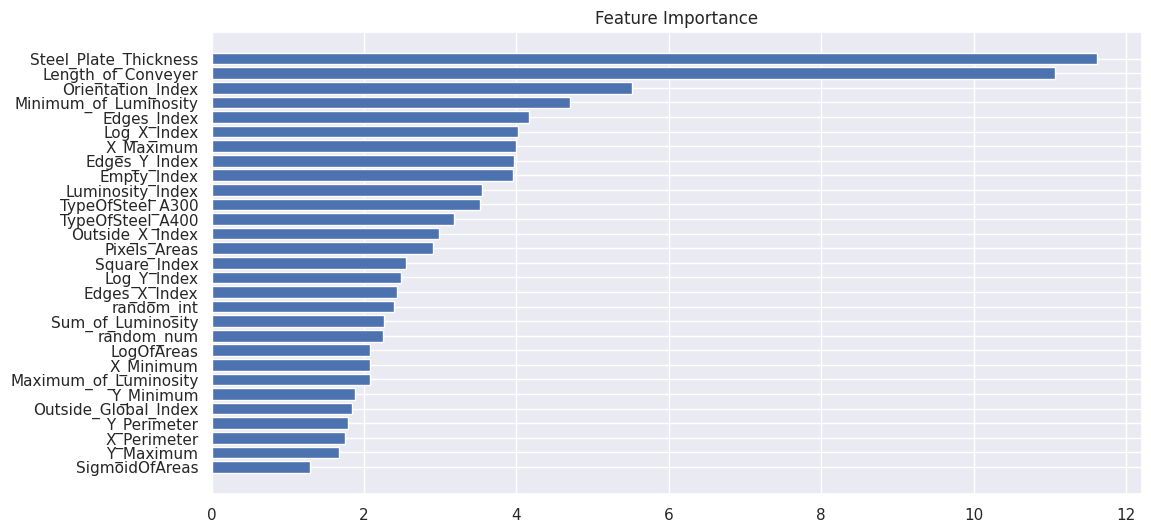

In [16]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

In [17]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8630099013104235

## 2.2 (5 мин)
* Постройте график Permutation importance
* Постройте Shap values
* Найти признаки, которые по важности оказались ниже рандомных - занести в список

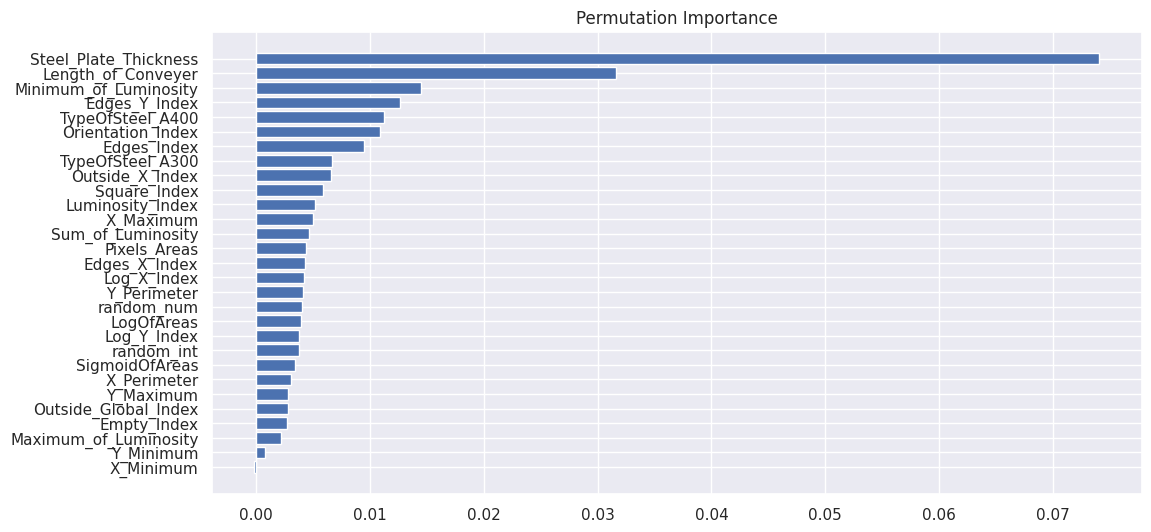

In [18]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

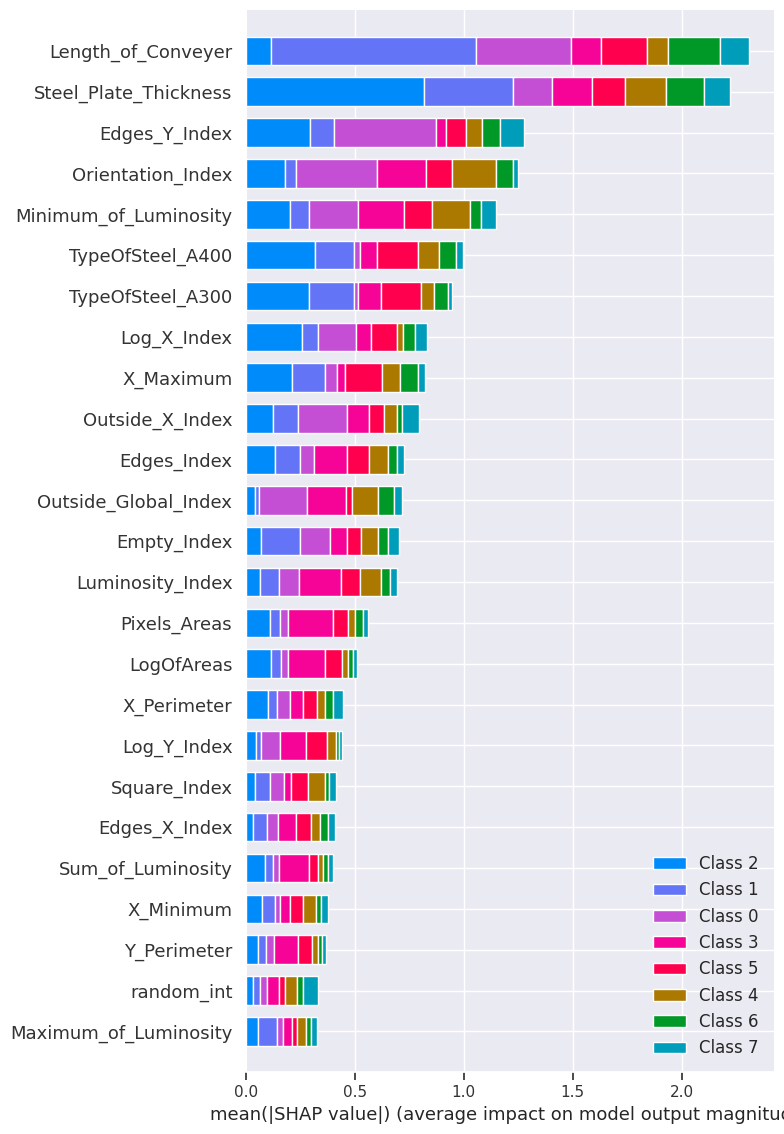

In [19]:
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

## 2.3. Recursive methods (5 мин)
* Запустить рекурсивный отбор фичей CatBoost
* Записать какие фичи он отобрал как неважные
* *Попробовать запустить BorutaShap после занятия 

In [20]:
summary = model.select_features(X_train, y_train, 
                      eval_set=(X_test, y_test),
                      features_for_select='0-28',
                      num_features_to_select=15, # указываем сколько признаков хотим оставить
                      steps=3,
                      train_final_model=False,
                      logging_level='Silent')

In [21]:
print(summary['selected_features_names'])
print()
print(summary['eliminated_features_names'])
print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

['Pixels_Areas', 'Y_Perimeter', 'Minimum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Outside_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index']

['Y_Maximum', 'random_int', 'Y_Minimum', 'random_num', 'Square_Index', 'X_Minimum', 'Edges_X_Index', 'Outside_Global_Index', 'Maximum_of_Luminosity', 'X_Perimeter', 'SigmoidOfAreas', 'Sum_of_Luminosity', 'Empty_Index', 'X_Maximum']
Best loss: 1.053585612832529


### Метод BorutaShap - можно попробовать дома (слишком долго считается)

In [22]:
#!pip install BorutaShap -q

In [23]:
# from sklearn.ensemble import RandomForestClassifier
# from BorutaShap import BorutaShap

# model = RandomForestClassifier(random_state=42, n_jobs=-1)
# Feature_Selector = BorutaShap(model=model,
#                               importance_measure='shap',
#                               classification=True)
# Feature_Selector.fit(X=X_train, y=y_train, n_trials=5, random_state=0)

# ИДЕИ для экспериментов:
* поэкспериментировать с признаком LogofAreas
* посмотреть импортансы с другими моделями
* посмотреть важность фичей для каждого таргета в отдельности

## 2.4 Собираем 2 списка фичей (10 мин)
* на основе проведённых экспериментов собираем топ (15 - 20) важных фичей в список important_features
* топ-10 мусорных фичей в список ignored_features
* Обучаем 2 модели CatBoost 1) только на топе важных 2)игнорируя топ мусорных
* Смотрим как изменился скор
* *Заслать сабмишены на ЛБ

In [24]:
important_features=['Pixels_Areas', 'Y_Perimeter', 'Minimum_of_Luminosity', 'Length_of_Conveyer',
                    'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index',
                    'Outside_X_Index', 'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index',
                    'Orientation_Index', 'Luminosity_Index', 'Y_Minimum', 'Y_Maximum']
ignored_features=['random_int', 'random_num', 
                  'Square_Index', 'X_Minimum', 'Edges_X_Index', 'Outside_Global_Index', 
                  'Maximum_of_Luminosity', 'X_Perimeter', 'SigmoidOfAreas', 'Sum_of_Luminosity', 
                  'Empty_Index', 'X_Maximum']

In [25]:
model = CatBoostClassifier(random_seed=43,
                           #ignored_features=[],
                           eval_metric='AUC',
                           )

model.fit(X_train[important_features], y_train, eval_set=(X_test[important_features], y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Learning rate set to 0.114039
0:	test: 0.7935088	best: 0.7935088 (0)	total: 40.8ms	remaining: 40.7s
50:	test: 0.9127472	best: 0.9127472 (50)	total: 1.63s	remaining: 30.4s
100:	test: 0.9168468	best: 0.9170214 (97)	total: 3.16s	remaining: 28.1s
150:	test: 0.9176241	best: 0.9177588 (142)	total: 5s	remaining: 28.1s
200:	test: 0.9172969	best: 0.9177588 (142)	total: 6.54s	remaining: 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9177587952
bestIteration = 142

Shrink model to first 143 iterations.
{'learn': {'MultiClass': 0.8744451307342197}, 'validation': {'AUC:type=Mu': 0.9177587952438797, 'MultiClass': 1.0464643032706045}}


In [26]:
y_pred = model.predict_proba(X_test[important_features])
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8616714292970064

In [27]:
model2 = CatBoostClassifier(random_seed=43,
                           ignored_features=ignored_features,
                           eval_metric='AUC',
                           )

model2.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model2.get_best_score())

Learning rate set to 0.114039
0:	test: 0.8025440	best: 0.8025440 (0)	total: 39.8ms	remaining: 39.8s
50:	test: 0.9120987	best: 0.9120987 (50)	total: 1.62s	remaining: 30.1s
100:	test: 0.9142800	best: 0.9143568 (99)	total: 3.12s	remaining: 27.7s
150:	test: 0.9155313	best: 0.9155313 (150)	total: 4.63s	remaining: 26s
200:	test: 0.9153790	best: 0.9158492 (181)	total: 6.12s	remaining: 24.3s
250:	test: 0.9150886	best: 0.9158492 (181)	total: 7.64s	remaining: 22.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9158491609
bestIteration = 181

Shrink model to first 182 iterations.
{'learn': {'MultiClass': 0.8512797572282943}, 'validation': {'AUC:type=Mu': 0.9158491609385101, 'MultiClass': 1.050820651782527}}


In [28]:
y_pred = model2.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8591946872976409

In [29]:
# подготовка файла для сабмишена
submission = pd.DataFrame(
    model.predict_proba(test[important_features])[:, :-1], # вписать модель и нужные фичи для предсказания
    columns=targets,
    index=test.id
).reset_index()
submission.to_csv('submission.csv', index=False)
submission.head(5)

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.498456,0.003462,0.002372,0.000145,0.019848,0.098031,0.341358
1,19220,0.308743,0.014050,0.008035,0.001270,0.161032,0.172215,0.303410
2,19221,0.002335,0.053882,0.104370,0.002218,0.006245,0.226695,0.518311
3,19222,0.093448,0.001342,0.000960,0.002727,0.009228,0.494259,0.366398
4,19223,0.001557,0.001818,0.001396,0.002001,0.013127,0.534910,0.397529


## 3. Найдите 2 рандомных признака из 20 (20 минут)

    Дан датасет, собранный из учебного про поломки машин
    В него добавлены 2 рандомных признака числовой и категориальный
    Используя любые методы из лекций, определите номера рандомных признаков
    
    Далее представлено много методов, которые могут помочь, но надо ли использовать их все?


In [30]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/779915/fs_task2_22f.csv')
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target_reg,target_class
0,0,4.101552,173,1,3.405865,88182,157.168032,1.973071e+07,0,1,0,24,2015,191.996603,2020,0.1,0,174,9,4.76,57.15,engine_ignition
1,0,4.303506,173,1,-2.218952,86897,121.805143,1.594185e+07,0,0,0,2,2015,193.547718,2015,0.1,1,174,7,4.26,60.82,engine_ignition
2,0,4.246379,174,1,-3.740321,44604,175.889164,2.127630e+07,0,0,0,27,2013,177.922027,2019,0.1,1,174,6,5.98,46.51,engine_ignition
3,0,4.342874,172,1,3.139031,114610,151.653445,2.250440e+07,0,0,0,49,2017,110.165268,2016,0.7,1,174,20,4.42,30.71,gear_stick
4,1,4.140287,148,0,-4.022916,114851,159.547387,1.163474e+07,0,0,1,4,2017,190.915943,2020,0.1,0,174,25,4.28,59.18,engine_fuel


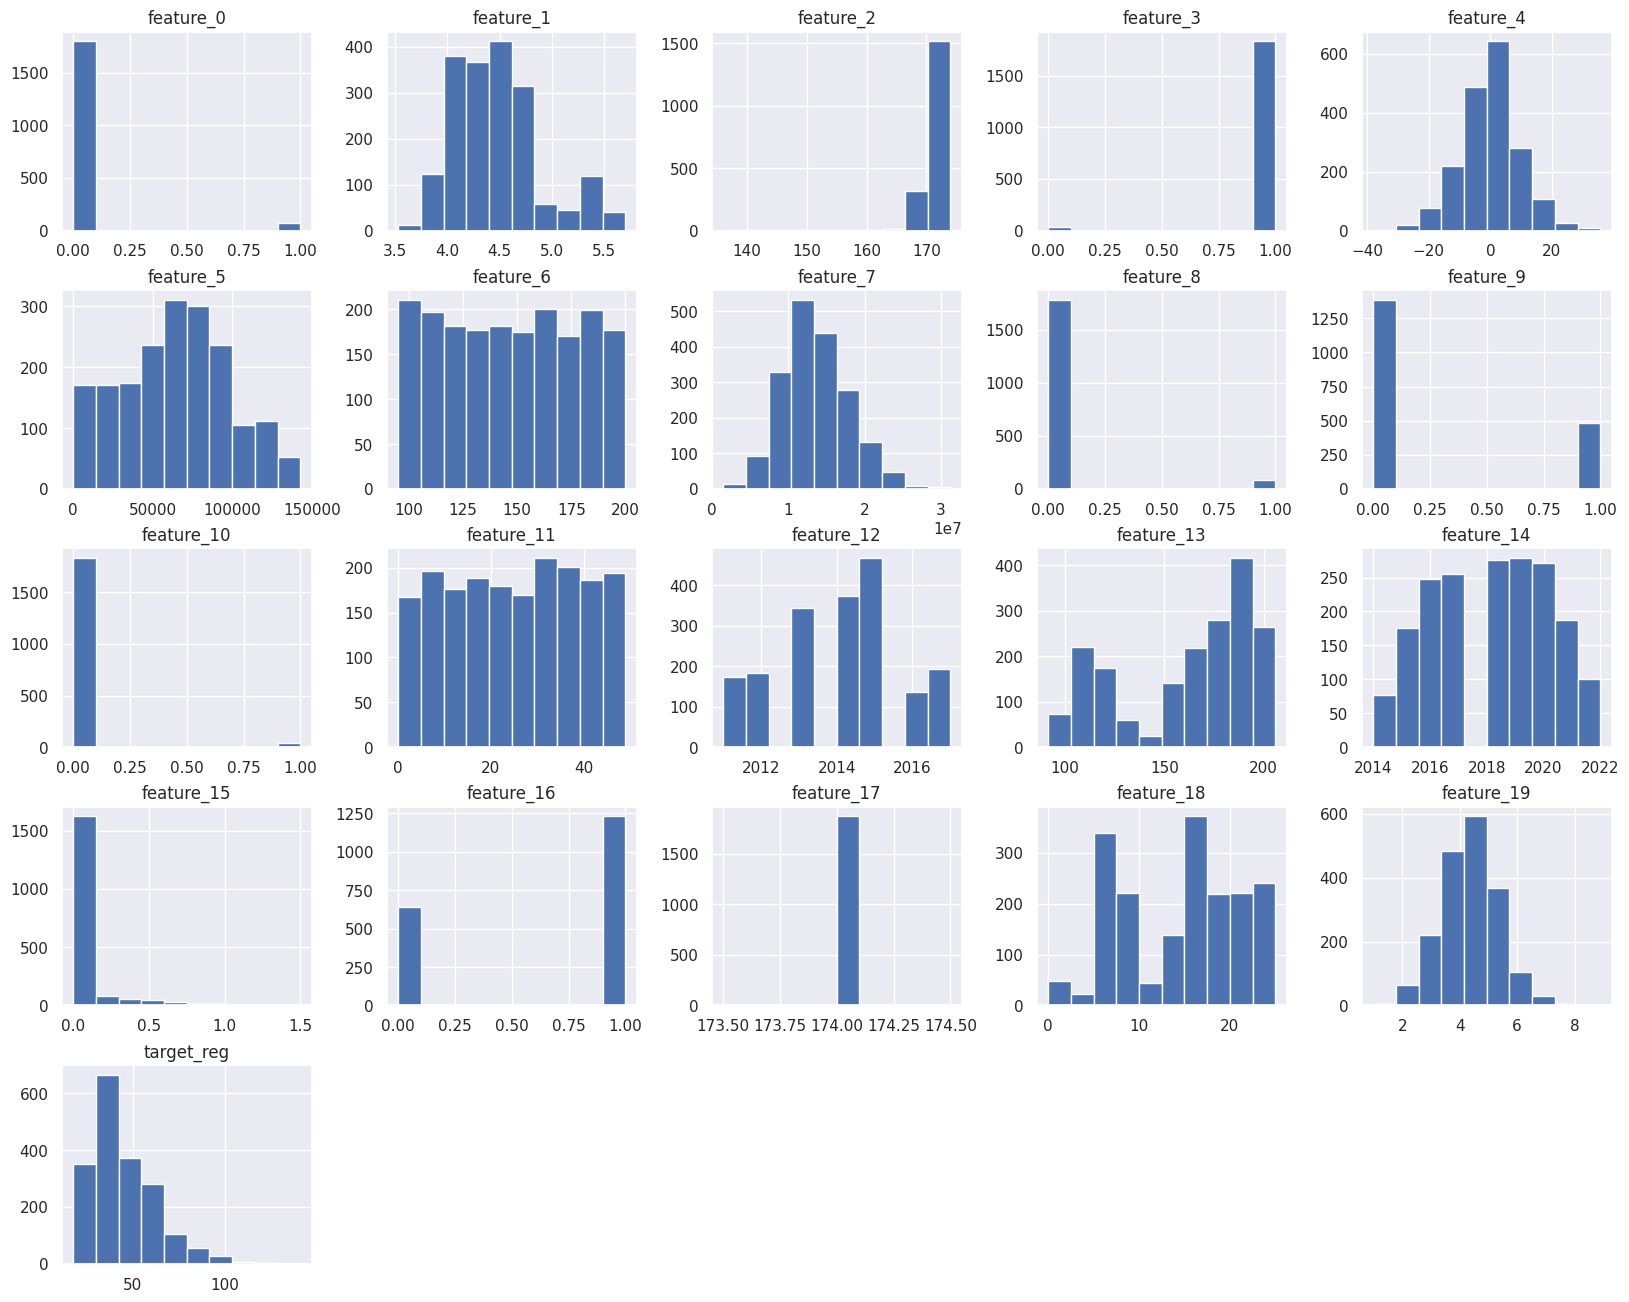

In [31]:
sns.set(rc={'figure.figsize': (20, 16)})
df.hist();

# Phik

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'target_reg']


Not enough unique value for variable feature_17 for analysis 1. Dropping this column


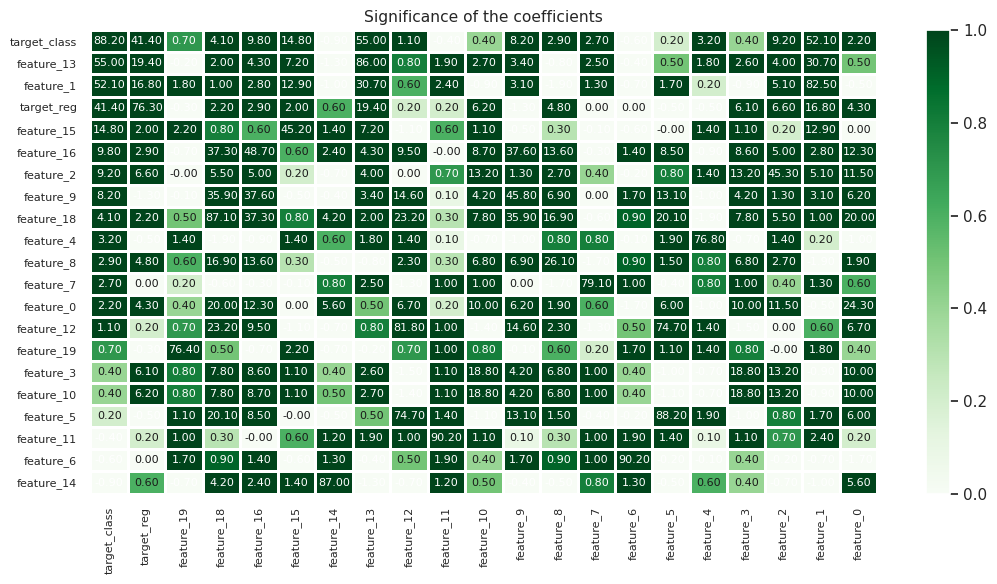

In [32]:
significance_overview = df.significance_matrix().fillna(0).round(1).sort_values('target_class')

plot_correlation_matrix(significance_overview.values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients",
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

# CB

In [33]:
drop_cols = ['target_class', 'target_reg']

X = df.drop(drop_cols, axis=1)
y = df['target_class'].fillna(0)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
model = CatBoostClassifier(random_seed=43,
                           #ignored_features=[],
                           eval_metric='AUC',
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
model.get_feature_importance(prettified=True)

Learning rate set to 0.10885
0:	test: 0.9473240	best: 0.9473240 (0)	total: 22.6ms	remaining: 22.5s
50:	test: 0.9821476	best: 0.9822668 (48)	total: 652ms	remaining: 12.1s
100:	test: 0.9799080	best: 0.9824671 (53)	total: 1.28s	remaining: 11.4s
150:	test: 0.9788562	best: 0.9824671 (53)	total: 1.89s	remaining: 10.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9824670681
bestIteration = 53

Shrink model to first 54 iterations.


,Feature Id,Importances
0,feature_13,37.450774
1,feature_1,35.662164
2,feature_15,17.220136
3,feature_2,2.580382
4,feature_4,0.962491
5,feature_7,0.891437
6,feature_6,0.825447
7,feature_5,0.681765
8,feature_19,0.629969
9,feature_12,0.625152


# Permutation importance

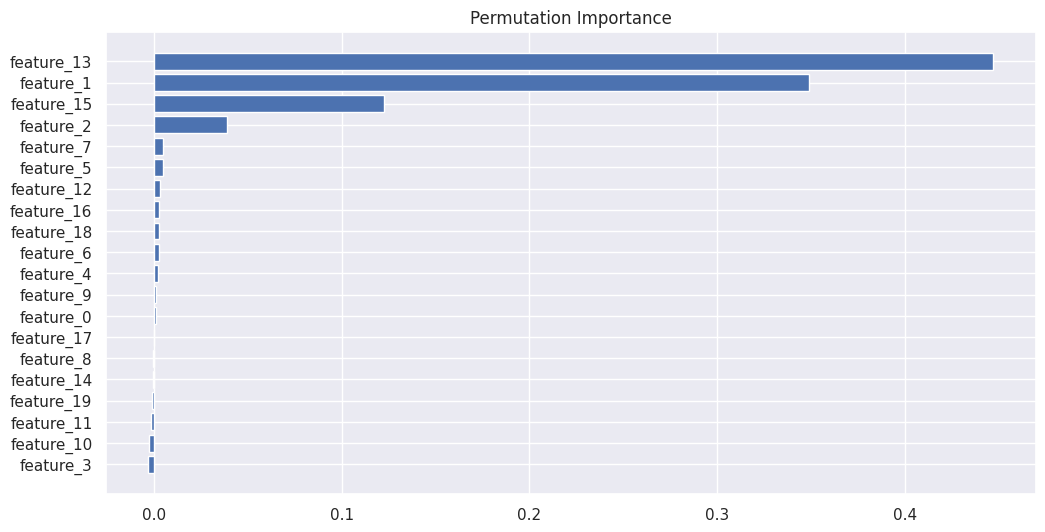

In [36]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

# Shap values

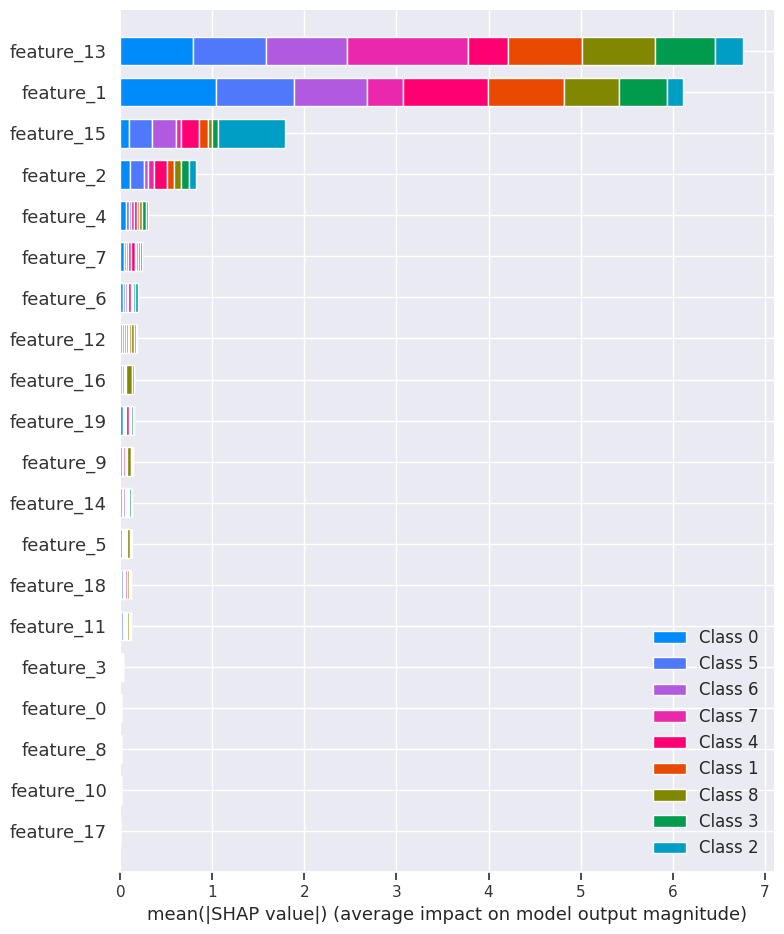

In [37]:
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

In [38]:
'feature_6', 'feature_11'

('feature_6', 'feature_11')